In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from datetime import datetime
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
train_df = pd.read_csv("titanic_train.csv")
Y_train = train_df["Survived"]
train_df.drop(labels="Survived",axis=1,inplace=True)
train_df["Survived"] = Y_train
test_df = pd.read_csv("titanic_test.csv")
N = len(train_df)
test_id = test_df["PassengerId"]
train_df.shape,test_df.shape

((891, 12), (418, 11))

In [3]:

train_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64

In [4]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [5]:
print(train_df.shape)
train_df.drop(train_df[((train_df["Age"]>70) & (train_df["Survived"]==1))].index,inplace=True)
train_df.shape

(891, 12)


(890, 12)

In [6]:
N=len(train_df)
Y_train =train_df["Survived"]
data = pd.concat([train_df.iloc[:,:-1],test_df],axis=0,ignore_index=True)
train_df.shape,test_df.shape,data.shape

((890, 12), (418, 11), (1308, 11))

In [7]:
data.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [8]:
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
data["Titles"] = data["Name"].apply(lambda x: ((((x.split(','))[1]).split('.'))[0]).strip() if len(x)>1 else x)

In [10]:

actual_titles={"Capt":"Officer",
              "Col": "Officer",
              "Major": "Officer",
              "Dr": "Officer",
              "Rev": "Officer",
              "the Countess":"Unknown",
              "Lady":"Unknown",
              "Mme":"Mrs",
              "Ms":"Miss",
              "Mlle":"Miss",
              "Mrs":"Mrs",
              "Miss":"Miss",
              "Dona":"Unknown",
              "Sir":"Unknown",
              "Master":"Master",
              "Jonkheer":"Unknown",
              "Mr":"Mr",
              "Don":"Unknown"
              }
data["Titles"]=data.Titles.map(actual_titles)

In [11]:
data["Titles"].value_counts()

Mr         756
Miss       264
Mrs        198
Master      61
Officer     23
Unknown      6
Name: Titles, dtype: int64

## Mapping to check does the survival have any dependency on titles

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


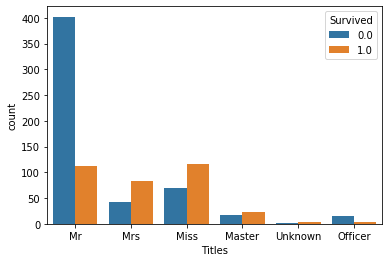

In [12]:
N=len(train_df)
train_df = data.iloc[:N]
test_df = data.iloc[N:]
train_df["Survived"] = Y_train
sns.countplot(x="Titles",hue="Survived",data=train_df)

As we can clearly see that the survival rate depends on the titles Mr has more no of non survivals in comparison to Mrs or Ms it means most of the males are helping females 

__Created Family Size Feature & Cabin_type__

In [13]:
#now we will be combining the two features to create one that is parch and SibSp as they basically defines family realtions so we will merge them to create one single feature
data["Family_size"] = (np.sum((data[["Parch","SibSp"]]),axis=1))+1

In [14]:
new_cabin =[0 for i in range(0,len(data))]

In [15]:
c=list(data["Cabin"])
k=[]
k.append(c[0])
k.append(c[2])
i=0
for x in c:
    if x in k:
        #print("in null column")
        alpha = k[0]
    else:
        #print("in not null")
        alpha = " ".join(re.split("[^A-Z]", x))
        aalpha = alpha.strip(
        
        )
        if len(alpha)>1:
            alpha =(alpha.split())[0] 
            
        #print(alpha,type(alpha))
    #print(no)
    new_cabin[i] = alpha
    i+=1

In [16]:
data["Cabin_type"] = new_cabin

In [17]:
data["Cabin_type"].value_counts()

C    94
B    65
D    46
E    41
A    21
F    21
G     5
T     1
Name: Cabin_type, dtype: int64

In [18]:
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,Family_size,Cabin_type
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,NaN
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,NaN
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,C
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,NaN


### Chceking about the Pclass on survival

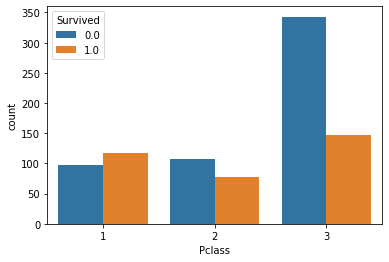

In [19]:
sns.countplot(x="Pclass",hue="Survived",data=train_df)

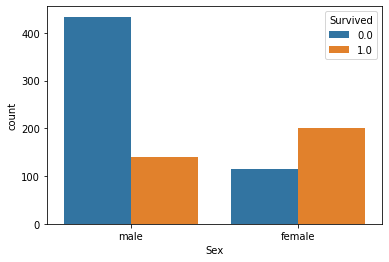

In [20]:
sns.countplot(x="Sex",hue="Survived",data=train_df)

From above two graphs we can see that the sex and pclass lays an important role in predicting the survival from 1st graph we can observe that 1st class passenger has more survival rate and from the below graph we can see that female survivours are more than male

Checking family size correlation with Survival

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


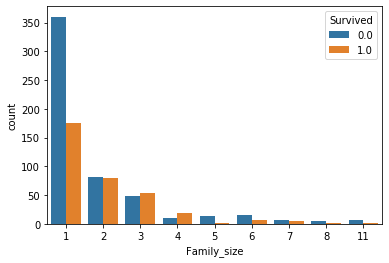

In [21]:
N=len(train_df)
train_df = data.iloc[:N]
test_df = data.iloc[N:]
train_df["Survived"] = Y_train
sns.countplot(x="Family_size",hue="Survived",data=train_df)

From above we can see that if a person is alone means family size is 1 than the chance of survival is less and for family size between 2 to 4 the survival rate is more than mortality rate but when the family size is more than 4 than rate of mortality is higher than survival

# Filling missing values in Age , Embarked, Fare 


## On the basis of

In [22]:
grouped_df =data.groupby(by=["Sex","Pclass","Titles"])
grouped_df.Age.median()

Sex     Pclass  Titles 
female  1       Miss       30.0
                Mrs        45.0
                Officer    49.0
                Unknown    39.0
        2       Miss       20.0
                Mrs        30.5
        3       Miss       18.0
                Mrs        31.0
male    1       Master      6.0
                Mr         41.0
                Officer    52.0
                Unknown    40.0
        2       Master      2.0
                Mr         30.0
                Officer    41.5
        3       Master      6.0
                Mr         26.0
Name: Age, dtype: float64

In [23]:
#filling ages on the basis of grouped data
data.Age = grouped_df.Age.apply(lambda x : x.fillna(x.median()))

In [24]:
data.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Titles            0
Family_size       0
Cabin_type     1014
dtype: int64

As fare and cabin has very less no of missing value so we will not go into much deeper to fill them

In [25]:
#one value is left out
data.loc[(data['Pclass'] == 1),'Fare'] = data.loc[(data['Pclass'] == 1),'Fare'].fillna(data.loc[(data['Pclass'] == 1),'Fare'].mean())
#one value is left out
data.loc[(data['Pclass'] == 2),'Fare'] = data.loc[(data['Pclass'] == 2),'Fare'].fillna(data.loc[(data['Pclass'] == 2),'Fare'].mean())
#one value is left out
data.loc[(data['Pclass'] == 3),'Fare'] = data.loc[(data['Pclass'] == 3),'Fare'].fillna(data.loc[(data['Pclass'] == 3),'Fare'].mean())

In [26]:
#one value is left out
data.loc[(data['Pclass'] == 1),'Embarked'] = data.loc[(data['Pclass'] == 1),'Embarked'].fillna(data.loc[(data['Pclass'] == 1),'Embarked'].mode()[0])
#one value is left out
data.loc[(data['Pclass'] == 2),'Embarked'] = data.loc[(data['Pclass'] == 2),'Embarked'].fillna(data.loc[(data['Pclass'] == 2),'Embarked'].mode()[0])
#one value is left out
data.loc[(data['Pclass'] == 3),'Embarked'] = data.loc[(data['Pclass'] == 3),'Embarked'].fillna(data.loc[(data['Pclass'] == 3),'Embarked'].mode()[0])

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


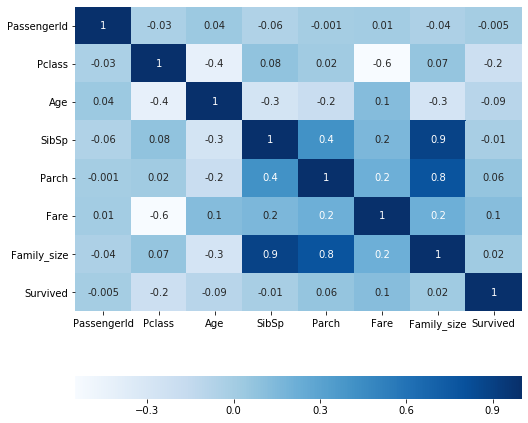

In [27]:
f, ax = plt.subplots(figsize=(8, 8))
train_df = data.iloc[:N]
train_df["Survived"] = Y_train
sns.heatmap(train_df.corr(), annot = True,fmt='.1g',cbar_kws= {'orientation': 'horizontal'},cmap="Blues" )


In [28]:
# checking if survival rate depends upon fare
#sns.barplot(x="Fare",hue="Survived",data=train_df)
train_df[["Fare","Survived"]].corr()


,Fare,Survived
Fare,1.000000,0.118691
Survived,0.118691,1.000000



as we can see fare is related to survival
but fare enough is not giving a proper idea because fare does not gives proper information as we can see one ticket is assign to multiple they may be family in some case and can also be an individual so we will introduce a new feature that is __fare per person__<br>
if the ticket is shared between multiple persons than we will divide fare among all the persons that will give the fare per person

In [29]:
grouped_df =data.groupby(by=["Ticket"])


for key, item in grouped_df:
    g_df = grouped_df.get_group(key)
    val = g_df["Cabin"].mode()
    print(g_df[['Ticket',"Pclass","Cabin_type","Fare","Family_size","Embarked"]])
    print("---------------------------------")

     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
257  110152       1          B  86.5            1        S
504  110152       1          B  86.5            1        S
758  110152       1          B  86.5            1        S
---------------------------------
     Ticket  Pclass Cabin_type   Fare  Family_size Embarked
262  110413       1          E  79.65            3        S
558  110413       1          E  79.65            3        S
585  110413       1          E  79.65            3        S
---------------------------------
     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
110  110465       1          C  52.0            1        S
475  110465       1          A  52.0            1        S
---------------------------------
      Ticket  Pclass Cabin_type  Fare  Family_size Embarked
1225  110469       1          C  26.0            1        S
---------------------------------
      Ticket  Pclass Cabin_type   Fare  Family_size Embarked
1048  110489       1          

    Ticket  Pclass Cabin_type  Fare  Family_size Embarked
23  113788       1          A  35.5            1        S
---------------------------------
     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
35   113789       1        NaN  52.0            2        S
383  113789       1        NaN  52.0            2        S
---------------------------------
      Ticket  Pclass Cabin_type   Fare  Family_size Embarked
1213  113790       1        NaN  26.55            1        S
---------------------------------
      Ticket  Pclass Cabin_type   Fare  Family_size Embarked
1038  113791       1        NaN  26.55            1        S
---------------------------------
     Ticket  Pclass Cabin_type   Fare  Family_size Embarked
467  113792       1        NaN  26.55            1        S
---------------------------------
     Ticket  Pclass Cabin_type   Fare  Family_size Embarked
447  113794       1        NaN  26.55            1        S
---------------------------------
      Ticket  Pclas

    Ticket  Pclass Cabin_type     Fare  Family_size Embarked
795  17465       1          D  25.9292            1        S
---------------------------------
    Ticket  Pclass Cabin_type     Fare  Family_size Embarked
861  17466       1          D  25.9292            1        S
---------------------------------
    Ticket  Pclass Cabin_type  Fare  Family_size Embarked
689  17474       1          B  57.0            2        S
780  17474       1          B  57.0            2        S
---------------------------------
     Ticket  Pclass Cabin_type   Fare  Family_size Embarked
1034  17475       1        NaN  26.55            1        S
---------------------------------
    Ticket  Pclass Cabin_type     Fare  Family_size Embarked
174  17764       1          A  30.6958            1        C
---------------------------------
     Ticket  Pclass Cabin_type     Fare  Family_size Embarked
1294  17765       1          D  27.7208            2        C
---------------------------------
     Ticket 

933  237249       2        NaN  13.0            1        S
---------------------------------
      Ticket  Pclass Cabin_type  Fare  Family_size Embarked
1054  237393       2        NaN  13.0            1        S
---------------------------------
     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
232  237442       2        NaN  13.5            1        S
---------------------------------
     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
586  237565       2        NaN  15.0            1        S
---------------------------------
     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
634  237668       2        NaN  13.0            1        S
---------------------------------
      Ticket  Pclass Cabin_type  Fare  Family_size Embarked
1236  237670       2        NaN  13.0            1        S
---------------------------------
     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
357  237671       2        NaN  13.0            1        S
-------------------------

799  250647       2        NaN  13.0            1        S
---------------------------------
     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
746  250648       2        NaN  13.0            1        S
---------------------------------
     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
247  250649       2        NaN  14.5            3        S
754  250649       2        NaN  14.5            3        S
---------------------------------
      Ticket  Pclass Cabin_type  Fare  Family_size Embarked
1128  250650       2        NaN  13.0            3        S
---------------------------------
      Ticket  Pclass Cabin_type  Fare  Family_size Embarked
312   250651       2        NaN  26.0            3        S
1039  250651       2        NaN  26.0            3        S
---------------------------------
     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
417  250652       2        NaN  13.0            3        S
---------------------------------
     Ticket  Pclass Cabi

    Ticket  Pclass Cabin_type     Fare  Family_size Embarked
140   2678       3        NaN  15.2458            3        C
851   2678       3        NaN  15.2458            3        C
970   2678       3        NaN  15.2458            3        C
---------------------------------
     Ticket  Pclass Cabin_type   Fare  Family_size Embarked
1127   2679       3        NaN  7.225            1        C
---------------------------------
     Ticket  Pclass Cabin_type     Fare  Family_size Embarked
73     2680       3        NaN  14.4542            2        C
1005   2680       3        NaN  14.4542            2        C
---------------------------------
     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
1006   2681       3        NaN  6.4375            1        C
---------------------------------
    Ticket  Pclass Cabin_type    Fare  Family_size Embarked
925   2682       3        NaN  7.2292            1        C
---------------------------------
    Ticket  Pclass Cabin_type    Fare 

      Ticket  Pclass Cabin_type   Fare  Family_size Embarked
104  3101276       3        NaN  7.925            3        S
---------------------------------
      Ticket  Pclass Cabin_type   Fare  Family_size Embarked
392  3101277       3        NaN  7.925            3        S
---------------------------------
      Ticket  Pclass Cabin_type   Fare  Family_size Embarked
85   3101278       3        NaN  15.85            4        S
206  3101278       3        NaN  15.85            2        S
---------------------------------
     Ticket  Pclass Cabin_type   Fare  Family_size Embarked
68  3101281       3        NaN  7.925            7        S
---------------------------------
       Ticket  Pclass Cabin_type     Fare  Family_size Embarked
50    3101295       3        NaN  39.6875            6        S
164   3101295       3        NaN  39.6875            6        S
266   3101295       3        NaN  39.6875            6        S
637   3101295       3        NaN  39.6875            6       

     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
956  330963       3        NaN  7.8792            1        Q
---------------------------------
      Ticket  Pclass Cabin_type    Fare  Family_size Embarked
1001  330968       3        NaN  7.7792            1        Q
---------------------------------
      Ticket  Pclass Cabin_type    Fare  Family_size Embarked
1123  330971       3        NaN  7.8792            1        Q
---------------------------------
     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
896  330972       3        NaN  7.6292            1        Q
---------------------------------
     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
552  330979       3        NaN  7.8292            1        Q
---------------------------------
     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
359  330980       3        NaN  7.8792            1        Q
---------------------------------
     Ticket  Pclass Cabin_type    Fare  Family_size Embarked

     Ticket  Pclass Cabin_type   Fare  Family_size Embarked
804  347063       3        NaN  7.775            1        S
---------------------------------
     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
406  347064       3        NaN  7.75            1        S
---------------------------------
      Ticket  Pclass Cabin_type   Fare  Family_size Embarked
1288  347065       3        NaN  7.775            1        S
---------------------------------
      Ticket  Pclass Cabin_type   Fare  Family_size Embarked
1087  347066       3        NaN  7.775            1        S
---------------------------------
     Ticket  Pclass Cabin_type   Fare  Family_size Embarked
231  347067       3        NaN  7.775            1        S
---------------------------------
     Ticket  Pclass Cabin_type   Fare  Family_size Embarked
162  347068       3        NaN  7.775            1        S
---------------------------------
     Ticket  Pclass Cabin_type   Fare  Family_size Embarked
379  347069   

961  349211       3        NaN  7.8958            1        S
---------------------------------
     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
876  349212       3        NaN  7.8958            1        S
---------------------------------
     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
846  349213       3        NaN  7.8958            1        C
---------------------------------
     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
601  349214       3        NaN  7.8958            1        S
---------------------------------
     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
101  349215       3        NaN  7.8958            1        S
---------------------------------
    Ticket  Pclass Cabin_type    Fare  Family_size Embarked
29  349216       3        NaN  7.8958            1        S
---------------------------------
     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
877  349217       3        NaN  7.8958            1        S
-----

     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
391  350034       3        NaN  7.7958            1        S
---------------------------------
     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
499  350035       3        NaN  7.7958            1        S
---------------------------------
     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
687  350036       3        NaN  7.7958            1        S
---------------------------------
     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
755  350042       3        NaN  7.7958            1        S
---------------------------------
     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
146  350043       3        NaN  7.7958            1        S
---------------------------------
      Ticket  Pclass Cabin_type    Fare  Family_size Embarked
1016  350045       3        NaN  7.7958            1        S
---------------------------------
     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
1

     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
653  365226       3        NaN  6.75            1        Q
---------------------------------
     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
992  365235       3        NaN  7.75            1        Q
---------------------------------
      Ticket  Pclass Cabin_type  Fare  Family_size Embarked
1300  365237       3        NaN  7.75            1        Q
---------------------------------
     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
717   36568       3        NaN  15.5            1        Q
1090  36568       3        NaN  15.5            1        Q
---------------------------------
      Ticket  Pclass Cabin_type  Fare  Family_size Embarked
1270  366713       3        NaN  7.75            1        Q
---------------------------------
      Ticket  Pclass Cabin_type   Fare  Family_size Embarked
301   367226       3        NaN  23.25            3        Q
330   367226       3        NaN  23.25            3    

     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
264  382649       3        NaN  7.75            1        Q
---------------------------------
      Ticket  Pclass Cabin_type  Fare  Family_size Embarked
1181  382650       3        NaN  6.95            1        Q
---------------------------------
     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
510  382651       3        NaN  7.75            1        Q
---------------------------------
     Ticket  Pclass Cabin_type    Fare  Family_size Embarked
16   382652       3        NaN  29.125            6        Q
171  382652       3        NaN  29.125            6        Q
278  382652       3        NaN  29.125            6        Q
786  382652       3        NaN  29.125            6        Q
884  382652       3        NaN  29.125            6        Q
945  382652       3        NaN  29.125            6        Q
---------------------------------
     Ticket  Pclass Cabin_type  Fare  Family_size Embarked
960  382653       3   

         Ticket  Pclass Cabin_type  Fare  Family_size Embarked
1303  A.5. 3236       3        NaN  8.05            1        S
---------------------------------
        Ticket  Pclass Cabin_type  Fare  Family_size Embarked
977  A/4 31416       3        NaN  8.05            1        S
---------------------------------
        Ticket  Pclass Cabin_type  Fare  Family_size Embarked
494  A/4 45380       3        NaN  8.05            1        S
---------------------------------
        Ticket  Pclass Cabin_type   Fare  Family_size Embarked
565  A/4 48871       3        NaN  24.15            3        S
810  A/4 48871       3        NaN  24.15            1        S
899  A/4 48871       3        NaN  24.15            3        S
---------------------------------
         Ticket  Pclass Cabin_type  Fare  Family_size Embarked
1077  A/4 48873       3        NaN  8.05            3        S
---------------------------------
         Ticket  Pclass Cabin_type  Fare  Family_size Embarked
574  A/4. 20589

               Ticket  Pclass Cabin_type  Fare  Family_size Embarked
882  C.A./SOTON 34068       2        NaN  10.5            1        S
---------------------------------
       Ticket  Pclass Cabin_type  Fare  Family_size Embarked
59    CA 2144       3        NaN  46.9            8        S
71    CA 2144       3        NaN  46.9            8        S
386   CA 2144       3        NaN  46.9            8        S
480   CA 2144       3        NaN  46.9            8        S
677   CA 2144       3        NaN  46.9            8        S
682   CA 2144       3        NaN  46.9            8        S
1029  CA 2144       3        NaN  46.9            8        S
1030  CA 2144       3        NaN  46.9            8        S
---------------------------------
        Ticket  Pclass Cabin_type  Fare  Family_size Embarked
1168  CA 31352       2        NaN  21.0            2        S
1252  CA 31352       2        NaN  21.0            1        S
---------------------------------
       Ticket  Pclass Cab

        Ticket  Pclass Cabin_type      Fare  Family_size Embarked
258   PC 17755       1        NaN  512.3292            1        C
678   PC 17755       1          B  512.3292            2        C
736   PC 17755       1          B  512.3292            1        C
1233  PC 17755       1          B  512.3292            2        C
---------------------------------
        Ticket  Pclass Cabin_type     Fare  Family_size Embarked
834   PC 17756       1          E  83.1583            3        C
1069  PC 17756       1          E  83.1583            3        C
1071  PC 17756       1          E  83.1583            3        C
---------------------------------
        Ticket  Pclass Cabin_type     Fare  Family_size Embarked
380   PC 17757       1        NaN  227.525            1        C
557   PC 17757       1        NaN  227.525            1        C
699   PC 17757       1          C  227.525            2        C
715   PC 17757       1          C  227.525            1        C
1092  PC 17757   

               Ticket  Pclass Cabin_type   Fare  Family_size Embarked
760  SOTON/O2 3101272       3        NaN  7.125            1        S
---------------------------------
                Ticket  Pclass Cabin_type   Fare  Family_size Embarked
1141  SOTON/O2 3101284       3        NaN  7.925            1        S
---------------------------------
               Ticket  Pclass Cabin_type   Fare  Family_size Embarked
839  SOTON/O2 3101287       3        NaN  7.925            1        S
---------------------------------
               Ticket  Pclass Cabin_type  Fare  Family_size Embarked
511  SOTON/OQ 3101316       3        NaN  8.05            1        S
---------------------------------
               Ticket  Pclass Cabin_type  Fare  Family_size Embarked
491  SOTON/OQ 3101317       3        NaN  7.25            1        S
---------------------------------
              Ticket  Pclass Cabin_type  Fare  Family_size Embarked
883  SOTON/OQ 392076       3        NaN  7.05            1      

In [30]:
ticket_value_counts = data.Ticket.value_counts()

In [31]:
fare_per_tic = [0 for i in range(0,len(data))]
i=0
for tic,fare in zip(data["Ticket"],data["Fare"]):
    no_occurence = ticket_value_counts[tic]
    fare_ = fare/no_occurence
    fare_per_tic[i] = fare_
    i+=1 

In [32]:
data["Fare_per_ticket"] = fare_per_tic

In [33]:
result=[]
for fam,fare in zip(data["Family_size"],data["Fare"]):
    fare_ = fare/fam
    result.append(fare_)

In [34]:
data["Fare_per_person"] = result

In [35]:
data[data["Fare_per_ticket"]!=data["Fare_per_person"]]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,Family_size,Cabin_type,Fare_per_ticket,Fare_per_person
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,NaN,7.250000,3.625000
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr,1,E,25.931250,51.862500
20,21,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S,Mr,1,NaN,13.000000,26.000000
31,32,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,45.0,1,0,PC 17569,146.5208,B78,C,Mrs,2,B,48.840267,73.260400
38,39,3,"Vander Planke, Miss. Augusta Maria",female,18.0,2,0,345764,18.0000,NaN,S,Miss,3,NaN,9.000000,6.000000
40,41,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,7546,9.4750,NaN,S,Mrs,2,NaN,9.475000,4.737500
50,51,3,"Panula, Master. Juha Niilo",male,7.0,4,1,3101295,39.6875,NaN,S,Master,6,NaN,5.669643,6.614583
52,53,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C,Mrs,2,D,25.576400,38.364600
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,S,Miss,1,B,40.000000,80.000000
68,69,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S,Miss,7,NaN,7.925000,1.132143


In [36]:
grouped_df =data[data["Pclass"]==1].groupby(by=["Cabin_type"])


for key, item in grouped_df:
    g_df = grouped_df.get_group(key)
    val = g_df["Cabin"].mode()
    print(g_df[['Ticket',"Age","Cabin_type","Fare_per_person","Family_size","Sex","Titles"]])
    print("---------------------------------")

        Ticket   Age Cabin_type  Fare_per_person  Family_size     Sex   Titles
23      113788  28.0          A          35.5000            1    male       Mr
96    PC 17754  71.0          A          34.6542            1    male       Mr
174      17764  56.0          A          30.6958            1    male       Mr
185     113767  41.0          A          50.0000            1    male       Mr
209     112277  40.0          A          31.0000            1    male       Mr
284     113056  41.0          A          26.0000            1    male       Mr
445      33638   4.0          A          27.2861            3    male   Master
475     110465  41.0          A          52.0000            1    male       Mr
556      11755  48.0          A          19.8000            2  female  Unknown
583      13049  36.0          A          40.1250            1    male       Mr
599   PC 17485  49.0          A          28.4646            2    male  Unknown
646      13213  56.0          A          35.5000    

In [37]:
grouped_df =data[data["Pclass"]==2].groupby(by=["Cabin_type"])


for key, item in grouped_df:
    g_df = grouped_df.get_group(key)
    val = g_df["Fare"].describe()
    print(g_df[["Age","Cabin_type","Fare_per_person","Family_size","Sex","Titles"]],val)
    print("---------------------------------")

       Age Cabin_type  Fare_per_person  Family_size     Sex Titles
21    34.0          D          13.0000            1    male     Mr
292   36.0          D          12.8750            1    male     Mr
327   36.0          D          13.0000            1  female    Mrs
473   23.0          D          13.7917            1  female    Mrs
1191  30.0          D          15.0458            1    male     Mr
1295  20.0          D          13.8625            1    male     Mr count     6.000000
mean     13.595833
std       0.829640
min      12.875000
25%      13.000000
50%      13.395850
75%      13.844800
max      15.045800
Name: Fare, dtype: float64
---------------------------------
      Age Cabin_type  Fare_per_person  Family_size     Sex Titles
123  32.5          E            13.00            1  female   Miss
303  20.0          E            12.35            1  female   Miss
716  27.0          E            10.50            1  female   Miss
771  57.0          E            10.50            1  fe

In [38]:
grouped_df =data[data["Pclass"]==3].groupby(by=["Cabin_type"])


for key, item in grouped_df:
    g_df = grouped_df.get_group(key)
    val = g_df["Fare_per_person"].describe()
    print(g_df[["Age","Cabin_type","Fare_per_person","Family_size","Sex","Titles"]],val)
    print("---------------------------------")

      Age Cabin_type  Fare_per_person  Family_size     Sex  Titles
429  32.0          E           8.0500            1    male      Mr
750   6.0          E           6.2375            2    male  Master
822  27.0          E           6.2375            2  female     Mrs count    3.000000
mean     6.841667
std      1.046447
min      6.237500
25%      6.237500
50%      6.237500
75%      7.143750
max      8.050000
Name: Fare_per_person, dtype: float64
---------------------------------
       Age Cabin_type  Fare_per_person  Family_size     Sex Titles
75    25.0          F         7.650000            1    male     Mr
128   18.0          F         7.452767            3  female   Miss
698   42.0          F         7.650000            1    male     Mr
714   19.0          F         7.650000            1    male     Mr
775   26.0          F         7.750000            1    male     Mr
947   25.0          F         7.650000            1    male     Mr
1178  26.0          F         7.229200         

In [39]:
data.sort_values(by="Cabin_type")["Cabin_type"].value_counts()

C    94
B    65
D    46
E    41
A    21
F    21
G     5
T     1
Name: Cabin_type, dtype: int64

In [40]:


data[(data["Pclass"]==2) ].sort_values(by="Cabin")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,Family_size,Cabin_type,Fare_per_ticket,Fare_per_person
473,474,2,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",female,23.0,0,0,SC/AH Basle 541,13.7917,D,C,Mrs,1,D,13.791700,13.791700
1191,1193,2,"Malachard, Mr. Noel",male,30.0,0,0,237735,15.0458,D,C,Mr,1,D,15.045800,15.045800
327,328,2,"Ball, Mrs. (Ada E Hall)",female,36.0,0,0,28551,13.0000,D,S,Mrs,1,D,13.000000,13.000000
292,293,2,"Levy, Mr. Rene Jacques",male,36.0,0,0,SC/Paris 2163,12.8750,D,C,Mr,1,D,12.875000,12.875000
1295,1297,2,"Nourney, Mr. Alfred (Baron von Drachstedt"")""",male,20.0,0,0,SC/PARIS 2166,13.8625,D38,C,Mr,1,D,13.862500,13.862500
21,22,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S,Mr,1,D,13.000000,13.000000
303,304,2,"Keane, Miss. Nora A",female,20.0,0,0,226593,12.3500,E101,Q,Miss,1,E,12.350000,12.350000
123,124,2,"Webber, Miss. Susan",female,32.5,0,0,27267,13.0000,E101,S,Miss,1,E,13.000000,13.000000
716,718,2,"Troutt, Miss. Edwina Celia ""Winnie""",female,27.0,0,0,34218,10.5000,E101,S,Miss,1,E,10.500000,10.500000
771,773,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5000,E77,S,Mrs,1,E,5.250000,10.500000


In [41]:
data[(data["Pclass"]==3) ].sort_values(by="Cabin")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,Family_size,Cabin_type,Fare_per_ticket,Fare_per_person
429,430,3,"Pickard, Mr. Berk (Berk Trembisky)",male,32.0,0,0,SOTON/O.Q. 392078,8.0500,E10,S,Mr,1,E,8.050000,8.050000
750,752,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S,Master,2,E,6.237500,6.237500
822,824,3,"Moor, Mrs. (Beila)",female,27.0,0,1,392096,12.4750,E121,S,Mrs,2,E,6.237500,6.237500
1178,1180,3,"Mardirosian, Mr. Sarkis",male,26.0,0,0,2655,7.2292,F E46,C,Mr,1,F,7.229200,7.229200
1211,1213,3,"Krekorian, Mr. Neshan",male,25.0,0,0,2654,7.2292,F E57,C,Mr,1,F,7.229200,7.229200
128,129,3,"Peter, Miss. Anna",female,18.0,1,1,2668,22.3583,F E69,C,Miss,3,F,7.452767,7.452767
698,700,3,"Humblen, Mr. Adolf Mathias Nicolai Olsen",male,42.0,0,0,348121,7.6500,F G63,S,Mr,1,F,7.650000,7.650000
947,949,3,"Abelseth, Mr. Olaus Jorgensen",male,25.0,0,0,348122,7.6500,F G63,S,Mr,1,F,7.650000,7.650000
75,76,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S,Mr,1,F,7.650000,7.650000
714,716,3,"Soholt, Mr. Peter Andreas Lauritz Andersen",male,19.0,0,0,348124,7.6500,F G73,S,Mr,1,F,7.650000,7.650000


In [42]:
grouped_df =data.groupby(by=["Pclass","Titles","Cabin_type"])
grouped_df.Fare.describe()

count        mean         std       min  \
Pclass Titles  Cabin_type                                            
1      Master  A             1.0   81.858300         NaN   81.8583   
               B             2.0  191.187500  100.674328  120.0000   
               C             1.0  151.550000         NaN  151.5500   
               E             1.0  134.500000         NaN  134.5000   
       Miss    A             2.0   29.700000    2.799011   27.7208   
               B            17.0  127.210541   81.822206   30.0000   
               C            17.0  154.925982   79.775517   26.5500   
               D             8.0   75.338538   30.704942   26.2833   
               E             6.0   90.622917   35.863020   55.0000   
       Mr      A            13.0   33.874677   13.482237    0.0000   
               B            24.0  113.799829  139.513722    0.0000   
               C            43.0   90.799228   71.112574   26.0000   
               D            19.0   52.887937   24.794635   26.5500   
               E            19.0   47.454605   28.284193   25.5875   
               T             1.0   35.500000         NaN   35.5000   
       Mrs     A             1.0   81.858300         NaN   81.8583   
               B            18.0  136.900000  121.050886   26.5500   
               C            28.0  106.072025   61.188378   25.7000   
               D            12.0   60.271192   17.200171   25.9292   
               E             8.0   72.240625   27.737532   53.1000   
       Officer A             2.0   58.679150   32.780268   35.5000   
               B             3.0   42.683333   24.602354   26.5500   
               C             4.0   94.131250   93.394070   28.5000   
               D             1.0   25.929200         NaN   25.9292   
       Unknown A             2.0   48.264600   12.253595   39.6000   
               B             1.0   86.500000         NaN   86.5000   
               C             1.0  108.900000         NaN  108.9000   
2      Master  F             3.0   30.333333    7.505553   26.0000   
       Miss    E             3.0   11.950000    1.297112   10.5000   
               F             3.0   30.333333   15.011107   13.0000   
       Mr      D             4.0   13.695825    1.001356   12.8750   
               F             3.0   17.333333    7.505553   13.0000   
       Mrs     D             2.0   13.395850    0.559816   13.0000   
               E             1.0   10.500000         NaN   10.5000   
               F             4.0   17.625000   14.250000   10.5000   
3      Master  E             1.0   12.475000         NaN   12.4750   
       Miss    F             1.0   22.358300         NaN   22.3583   
               G             3.0   14.620833    3.601222   10.4625   
       Mr      E             1.0    8.050000         NaN    8.0500   
               F             7.0    7.544057    0.218166    7.2292   
       Mrs     E             1.0   12.475000         NaN   12.4750   
               G             2.0   13.581250    4.410579   10.4625   

                                  25%        50%         75%       max  
Pclass Titles  Cabin_type                                               
1      Master  A            81.858300   81.85830   81.858300   81.8583  
               B           155.593750  191.18750  226.781250  262.3750  
               C           151.550000  151.55000  151.550000  151.5500  
               E           134.500000  134.50000  134.500000  134.5000  
       Miss    A            28.710400   29.70000   30.689600   31.6792  
               B            69.300000   86.50000  211.337500  262.3750  
               C            90.000000  153.46250  221.779200  263.0000  
               D            67.068775   77.95830   87.018775  113.2750  
               E            62.609400   81.40415  121.664575  134.5000  
       Mr      A            29.700000   31.00000   40.125000   52.0000  
               B            40.250000   79.20000  100.125000  512.3292

In [43]:
grouped_df =train_df.groupby(by=["Pclass","Titles","Age","Cabin_type"])
grouped_df.Fare.describe()

count      mean         std       min  \
Pclass Titles  Age   Cabin_type                                          
1      Master  0.92  C             1.0  151.5500         NaN  151.5500   
               4.00  A             1.0   81.8583         NaN   81.8583   
               11.00 B             1.0  120.0000         NaN  120.0000   
       Miss    2.00  C             1.0  151.5500         NaN  151.5500   
               14.00 B             1.0  120.0000         NaN  120.0000   
               15.00 B             1.0  211.3375         NaN  211.3375   
               16.00 B             2.0   72.2396   20.167251   57.9792   
                     D             1.0   39.4000         NaN   39.4000   
               18.00 B             1.0  262.3750         NaN  262.3750   
                     E             1.0   79.6500         NaN   79.6500   
               19.00 B             1.0   30.0000         NaN   30.0000   
                     D             1.0   26.2833         NaN   26.2833   
               21.00 B             1.0  262.3750         NaN  262.3750   
                     D             1.0   77.9583         NaN   77.9583   
               22.00 B             1.0   49.5000         NaN   49.5000   
                     E             1.0   55.0000         NaN   55.0000   
               23.00 C             1.0  263.0000         NaN  263.0000   
                     D             1.0  113.2750         NaN  113.2750   
               24.00 B             1.0   69.3000         NaN   69.3000   
                     C             3.0  131.8875  114.786826   49.5042   
               29.00 B             1.0  211.3375         NaN  211.3375   
               30.00 B             2.0   90.0000    4.949747   86.5000   
                     E             1.0   56.9292         NaN   56.9292   
               31.00 C             1.0  164.8667         NaN  164.8667   
                     D             1.0  113.2750         NaN  113.2750   
               32.00 D             1.0   76.2917         NaN   76.2917   
               33.00 C             1.0   90.0000         NaN   90.0000   
               35.00 C             1.0  135.6333         NaN  135.6333   
               36.00 B             1.0   71.0000         NaN   71.0000   
                     C             1.0  135.6333         NaN  135.6333   
...                                ...       ...         ...       ...   
       Unknown 48.00 A             1.0   39.6000         NaN   39.6000   
               49.00 A             1.0   56.9292         NaN   56.9292   
2      Master  2.00  F             1.0   26.0000         NaN   26.0000   
               1.00  F             1.0   39.0000         NaN   39.0000   
               3.00  F             1.0   26.0000         NaN   26.0000   
       Miss    4.00  F             1.0   39.0000         NaN   39.0000   
               24.00 F             1.0   13.0000         NaN   13.0000   
               27.00 E             1.0   10.5000         NaN   10.5000   
               20.00 E             1.0   12.3500         NaN   12.3500   
               32.50 E             1.0   13.0000         NaN   13.0000   
       Mr      36.00 D             1.0   12.8750         NaN   12.8750   
               34.00 D             1.0   13.0000         NaN   13.0000   
               36.50 F             1.0   26.0000         NaN   26.0000   
       Mrs     23.00 D             1.0   13.7917         NaN   13.7917   
               29.00 F             1.0   10.5000         NaN   10.5000   
               36.00 D             1.0   13.0000         NaN   13.0000   
               34.00 F             1.0   10.5000         NaN   10.5000   
               57.00 E             1.0   10.5000         NaN   10.5000   
3      Master  6.00  E             1.0   12.4750         NaN   12.4750   
       Miss    4.00  G             1.0   16.7000         NaN   16.7000   
               2.00  G             1.0   10.4625         NaN   10.4625   
               18.00 F             1.

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


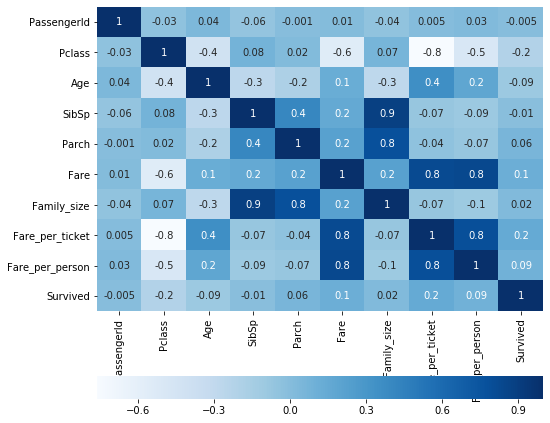

In [44]:
f, ax = plt.subplots(figsize=(8, 8))
train_df = data.iloc[:N]
train_df["Survived"] = Y_train
sns.heatmap(train_df.corr(), annot = True,fmt='.1g',cbar_kws= {'orientation': 'horizontal'},cmap="Blues" )


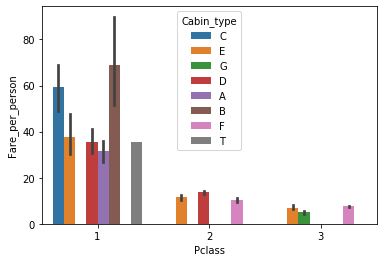

In [45]:
sns.barplot(x="Pclass",y="Fare_per_person",hue="Cabin_type",data=data)

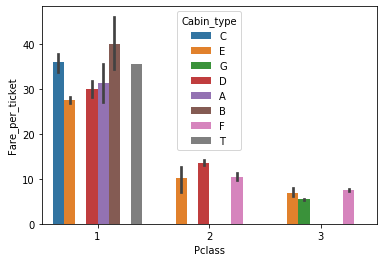

In [46]:
sns.barplot(x="Pclass",y="Fare_per_ticket",hue="Cabin_type",data=data)

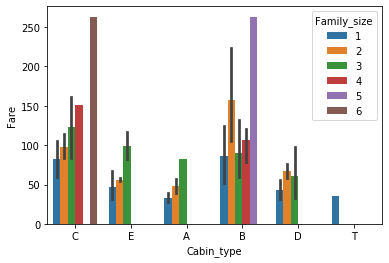

In [47]:
sns.barplot(x="Cabin_type",y="Fare",hue="Family_size",data=data[data["Pclass"]==1])

## As we can see Fare has lot of skewness 
To deal with skewness we need to remove outliner either by log transfromation or by binning the fare column . for binning the most important factor is no of bins required to map our data for finding the ideal no of bins we will be using __Sturges Rule__ -  which tells about the no of bins to be used by the formula

$$h=\frac{b-a}{K}$$
b is upper bound a is lower bound and h is the width
$$k = 1+log(N)$$

N is length of the data

Fare 2.7277063280299805


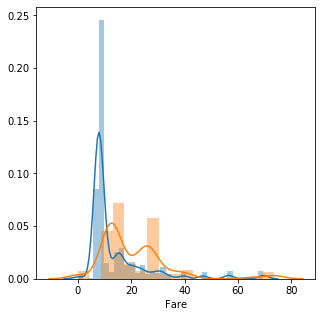

In [48]:
# checking the skewess in the fare column
print("Fare",skew(train_df[train_df["Pclass"]==3]["Fare"]))
plt.figure(figsize=(5,5))
sns.distplot(train_df[train_df["Pclass"]==3]["Fare"])
sns.distplot(train_df[train_df["Pclass"]==2]["Fare"],label="Class 2 Fare")
plt.show()

Fare 4.776437018701282


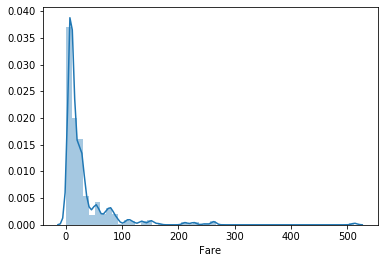

In [49]:
# checking the skewess in the fare column
print("Fare",skew(train_df["Fare"]))
plt.figure()
sns.distplot(train_df["Fare"])
plt.show()

Fare_per_person 7.750121962301546


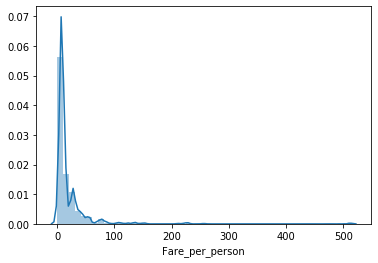

In [50]:
# checking the skewess in the fare column
print("Fare_per_person",skew(train_df["Fare_per_person"]))
plt.figure()
sns.distplot(train_df["Fare_per_person"])
plt.show()

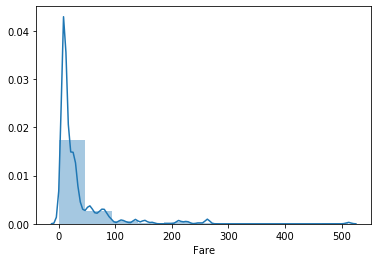

In [51]:
#np.log(data["Fare"]+1).hist(bins=3)
sns.distplot(data["Fare"],bins=11)

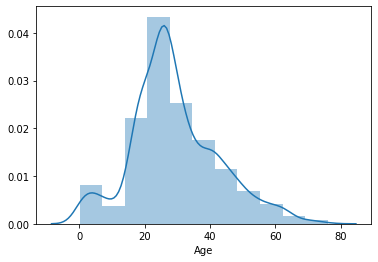

In [52]:
#np.log(data["Fare"]+1).hist(bins=3)
sns.distplot(data["Age"],bins=11)

## Binning the Fare column

In [53]:
no_bins = int(1+np.log2(len(data)))

In [54]:
data["Fare"] = pd.qcut(data["Fare"],q=no_bins,labels=list(range(0,11)))
data["Fare_per_person"] = pd.qcut(data["Fare_per_person"],q=no_bins,labels=list(range(0,11)))
data["Fare_per_ticket"] = pd.qcut(data["Fare_per_ticket"],q=no_bins,labels=list(range(0,11)))
data["Age"] = pd.qcut(data["Age"],q=no_bins,labels=list(range(0,11)))

In [55]:
data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,Family_size,Cabin_type,Fare_per_ticket,Fare_per_person
0,1,3,"Braund, Mr. Owen Harris",male,2,1,0,A/5 21171,0,NaN,S,Mr,2,NaN,2,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,8,1,0,PC 17599,9,C85,C,Mrs,2,C,10,9
2,3,3,"Heikkinen, Miss. Laina",female,4,0,0,STON/O2. 3101282,2,NaN,S,Miss,1,NaN,4,4
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,7,1,0,113803,9,C123,S,Mrs,2,C,8,8
4,5,3,"Allen, Mr. William Henry",male,7,0,0,373450,3,NaN,S,Mr,1,NaN,4,4
5,6,3,"Moran, Mr. James",male,4,0,0,330877,3,NaN,Q,Mr,1,NaN,5,5
6,7,1,"McCarthy, Mr. Timothy J",male,10,0,0,17463,9,E46,S,Mr,1,E,8,10
7,8,3,"Palsson, Master. Gosta Leonard",male,0,3,1,349909,6,NaN,S,Master,5,NaN,0,0
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,5,0,2,347742,4,NaN,S,Mrs,3,NaN,0,0
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,0,1,0,237736,8,NaN,C,Mrs,2,NaN,8,7


# ROUGHHHH

In [56]:
result=[]
for tic in data["Ticket"]:
    freq = ticket_value_counts[tic]
    result.append(freq)
data["Ticket_freq"] = result

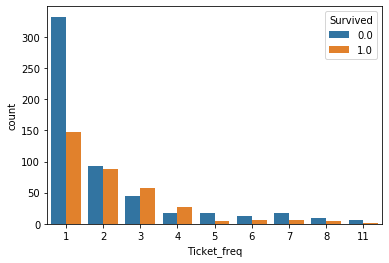

In [57]:
x =data.iloc[:N].copy()
x["Survived"] = Y_train
sns.countplot(x="Ticket_freq",hue="Survived",data=x)

In [58]:
result=[]
for name in data["Name"]:
    nam = len(name)
    result.append(nam)
data["name_length"] = result

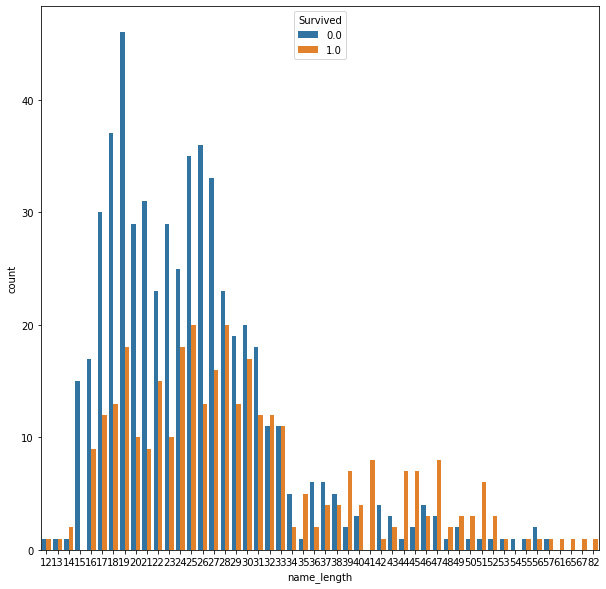

In [59]:
x =data.iloc[:N].copy()
x["Survived"] = Y_train
plt.figure(figsize=(10,10))
sns.countplot(x="name_length",hue="Survived",data=x,)

In [60]:
x.pivot_table(index="name_length",values=["Survived"], aggfunc=np.mean)

,Survived
name_length,
12,0.500000
13,0.500000
14,0.666667
15,0.000000
16,0.346154
17,0.285714
18,0.260000
19,0.281250
20,0.256410


__Ticket frequency__ as we can say from the above observation that for ticket frequency 2 to 4 the survival rate is higher than mortality rate and for other visa-versa so we can see that survival rate depends a bit on ticket frequency
__Name Length__ from the graph above we can see that some of the name length has higer survival rate than other so its some kind of information we can use for predicting survival

In [61]:
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,Family_size,Cabin_type,Fare_per_ticket,Fare_per_person,Ticket_freq,name_length
0,1,3,"Braund, Mr. Owen Harris",male,2,1,0,A/5 21171,0,NaN,S,Mr,2,NaN,2,0,1,23
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,8,1,0,PC 17599,9,C85,C,Mrs,2,C,10,9,2,51
2,3,3,"Heikkinen, Miss. Laina",female,4,0,0,STON/O2. 3101282,2,NaN,S,Miss,1,NaN,4,4,1,22
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,7,1,0,113803,9,C123,S,Mrs,2,C,8,8,2,44
4,5,3,"Allen, Mr. William Henry",male,7,0,0,373450,3,NaN,S,Mr,1,NaN,4,4,1,24


In [62]:
# dropping unnecessary column
data.drop(labels=["Name","PassengerId","Ticket","Cabin"],axis=1,inplace=True)

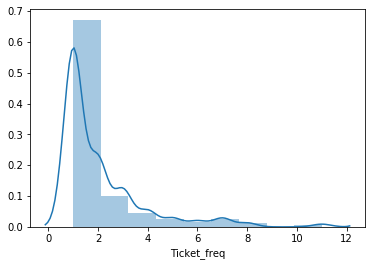

In [63]:
#np.log(data["Fare"]+1).hist(bins=3)
sns.distplot(data["Ticket_freq"],bins=9)

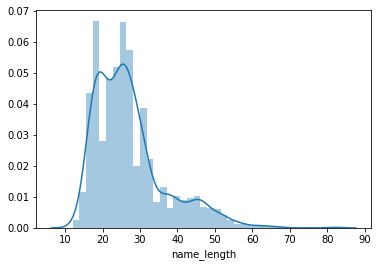

In [64]:
#np.log(data["Fare"]+1).hist(bins=3)
sns.distplot(data["name_length"])

In [65]:
for col in data.columns:
    print(col,data[col].dtype)

Pclass int64
Sex object
Age category
SibSp int64
Parch int64
Fare category
Embarked object
Titles object
Family_size int64
Cabin_type object
Fare_per_ticket category
Fare_per_person category
Ticket_freq int64
name_length int64


In [66]:
data["Sex"] = LabelEncoder().fit_transform(data["Sex"])
data["Embarked"] = LabelEncoder().fit_transform(data["Embarked"])
data["Titles"] = LabelEncoder().fit_transform(data["Titles"])
#data["Cabin_type"] = LabelEncoder().fit_transform(data["Cabin_type"])

In [67]:
# As we can see that pclass has certain type of cabin so basically they kinda have order
data["Cabin_type"].replace(to_replace=["T","A","B","C","D","E","F","G"],value = [0,1,2,3,4,5,6,7],inplace=True)

In [68]:
data.drop(labels=["SibSp","Parch"],axis=1,inplace=True)

In [69]:
data

,Pclass,Sex,Age,Fare,Embarked,Titles,Family_size,Cabin_type,Fare_per_ticket,Fare_per_person,Ticket_freq,name_length
0,3,1,2,0,2,2,2,NaN,2,0,1,23
1,1,0,8,9,0,3,2,3.0,10,9,2,51
2,3,0,4,2,2,1,1,NaN,4,4,1,22
3,1,0,7,9,2,3,2,3.0,8,8,2,44
4,3,1,7,3,2,2,1,NaN,4,4,1,24
5,3,1,4,3,1,2,1,NaN,5,5,1,16
6,1,1,10,9,2,2,1,5.0,8,10,2,23
7,3,1,0,6,2,0,5,NaN,0,0,5,30
8,3,0,5,4,2,3,3,NaN,0,0,3,49
9,2,0,0,8,0,3,2,NaN,8,7,2,35


In [70]:
#data.drop(labels="Cabin_type",axis=1,inplace=True)

In [71]:
data.head()

,Pclass,Sex,Age,Fare,Embarked,Titles,Family_size,Cabin_type,Fare_per_ticket,Fare_per_person,Ticket_freq,name_length
0,3,1,2,0,2,2,2,NaN,2,0,1,23
1,1,0,8,9,0,3,2,3.0,10,9,2,51
2,3,0,4,2,2,1,1,NaN,4,4,1,22
3,1,0,7,9,2,3,2,3.0,8,8,2,44
4,3,1,7,3,2,2,1,NaN,4,4,1,24


In [72]:
data =pd.get_dummies(data,columns=["Cabin_type","Embarked","Sex","Pclass","Titles","Family_size"])

In [73]:
data["Age"] = data["Age"].astype("int")
data["Fare"] = data["Fare"].astype("int")
data["Fare_per_person"] = data["Fare_per_person"].astype("int")
data["Fare_per_ticket"] = data["Fare_per_ticket"].astype("int")

# BASELINE PERFORMANCE

In [74]:
train = data.iloc[:(N-80)]
cv = data.iloc[(N-80):N]
test=data.iloc[N:]
Y_train_ = Y_train[:(N-80)]
Y_train_cv = Y_train[(N-80):]
train.shape,test.shape,Y_train_.shape,cv.shape,Y_train_cv.shape

((810, 37), (418, 37), (810,), (80, 37), (80,))

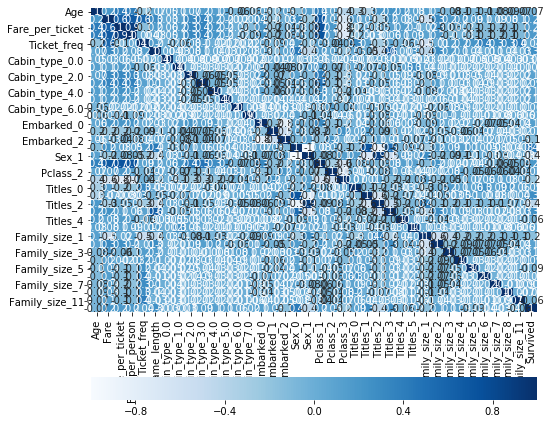

In [75]:
f, ax = plt.subplots(figsize=(8, 8))
train_df = train.iloc[:N].copy()
train_df["Survived"] = Y_train_
sns.heatmap(train_df.corr(), annot = True,fmt='.1g',cbar_kws= {'orientation': 'horizontal'},cmap="Blues" )


In [76]:
train.head()

,Age,Fare,Fare_per_ticket,Fare_per_person,Ticket_freq,name_length,Cabin_type_0.0,Cabin_type_1.0,Cabin_type_2.0,Cabin_type_3.0,...,Titles_5,Family_size_1,Family_size_2,Family_size_3,Family_size_4,Family_size_5,Family_size_6,Family_size_7,Family_size_8,Family_size_11
0,2,0,2,0,1,23,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,8,9,10,9,2,51,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,4,2,4,4,1,22,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,7,9,8,8,2,44,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,7,3,4,4,1,24,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [77]:
model = XGBClassifier(random_state=42)
model.fit(train, Y_train_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [78]:
y_pred = model.predict(test)

In [79]:
# actual test so that we can compare the accuracy
submission_csv =pd.read_csv("gender_submission.csv") 
submission_id = submission_csv["PassengerId"]
Y_test = submission_csv["Survived"]

In [80]:
# test accuracy score
accuracy_score(Y_test, y_pred)

1.0

In [81]:
# train acccuracy score
accuracy_score(Y_train_, model.predict(train))

0.9814814814814815

In [82]:
accuracy = cross_val_score(model, train,Y_train_, scoring='accuracy', cv = StratifiedKFold(n_splits=5,shuffle=True))
print(accuracy.mean())

0.8111111111111111


In [83]:
# test accuracy score
accuracy_score(Y_train_cv, model.predict(cv))

0.8375

In [84]:
accuracy = cross_val_score(model, cv,Y_train_cv, scoring='accuracy', cv = StratifiedKFold(n_splits=5,shuffle=True))
print(accuracy.mean())

0.7625


In [85]:
data.columns

Index(['Age', 'Fare', 'Fare_per_ticket', 'Fare_per_person', 'Ticket_freq',
       'name_length', 'Cabin_type_0.0', 'Cabin_type_1.0', 'Cabin_type_2.0',
       'Cabin_type_3.0', 'Cabin_type_4.0', 'Cabin_type_5.0', 'Cabin_type_6.0',
       'Cabin_type_7.0', 'Embarked_0', 'Embarked_1', 'Embarked_2', 'Sex_0',
       'Sex_1', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Titles_0', 'Titles_1',
       'Titles_2', 'Titles_3', 'Titles_4', 'Titles_5', 'Family_size_1',
       'Family_size_2', 'Family_size_3', 'Family_size_4', 'Family_size_5',
       'Family_size_6', 'Family_size_7', 'Family_size_8', 'Family_size_11'],
      dtype='object')

In [86]:
k =list(zip(model.feature_importances_,data.columns))

In [87]:
k.sort(reverse=True)

In [88]:
len(k)

37

In [89]:
imp_col =list(dict(k[:22]).values())

In [90]:
imp_col

['Titles_2',
 'Titles_4',
 'Pclass_3',
 'Pclass_1',
 'Ticket_freq',
 'Cabin_type_4.0',
 'Cabin_type_5.0',
 'Embarked_1',
 'Family_size_4',
 'Fare_per_person',
 'Cabin_type_2.0',
 'Cabin_type_3.0',
 'Family_size_3',
 'Age',
 'Fare_per_ticket',
 'Fare',
 'Family_size_1',
 'name_length',
 'Sex_0',
 'Family_size_7',
 'Embarked_0',
 'Titles_1']

In [91]:
submission_df = pd.DataFrame()
submission_df["PassengerId"] = test_id
submission_df["Survived"] = y_pred
submission_df.to_csv("gender_submission.csv",index=False)

# Hyperparameter tuning

In [92]:
data=data[imp_col]

In [93]:
train = data.iloc[:(N-80)]
cv = data.iloc[(N-80):N]
test=data.iloc[N:]
Y_train_ = Y_train[:(N-80)]
Y_train_cv = Y_train[(N-80):]
train.shape,test.shape,Y_train_.shape,cv.shape,Y_train_cv.shape

((810, 22), (418, 22), (810,), (80, 22), (80,))

In [94]:
xgb_model = XGBClassifier()
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("start Time =", current_time)
parameters_dict = {"n_estimators":[1100,1500,2000,3000,4000],
                  "gamma":[0.1,0.2,0.3,0.5,0.8],
                   "booster":[ "gbtree"],
                   "learning_rate": [0.05,0.005,0.01,0.001,0.025,0.03],
                   "reg_alpha": np.random.uniform(0.1,0.3,size =5),
                   "reg_lambda": np.random.uniform(0.1,0.3,size =5),
                   "min_child_weight":[1,2,3,4],
                   "max_depth":[2,4,6,5]
                  }

# creating the random search object from finding the best parameters
search = RandomizedSearchCV(xgb_model,param_distributions=parameters_dict,random_state=42,verbose=True,n_jobs=-1,n_iter=200,return_train_score=True,cv=10)
#neg-mean-absolute-error

# training the random search cv
search.fit(train,Y_train_)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("end Time =", current_time)

#  Printing the scores
print("Best parameters",search.best_params_)
print("Best Scores",search.best_score_)


start Time = 20:47:30
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 36.5min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 39.5min finished


end Time = 21:27:03
Best parameters {'reg_lambda': 0.2954006897682916, 'reg_alpha': 0.22557109678466683, 'n_estimators': 2000, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.001, 'gamma': 0.5, 'booster': 'gbtree'}
Best Scores 0.8444444444444444


In [95]:
#As we can see the best parameters area
best_parameters = search.best_params_

In [96]:
xg_model = XGBClassifier(max_depth =best_parameters['max_depth'], reg_lambda= best_parameters['reg_lambda'],reg_alpha= best_parameters['reg_alpha'],n_estimators=best_parameters['n_estimators'],learning_rate= best_parameters['learning_rate'],gamma=best_parameters['gamma'] ,booster=best_parameters['booster'],min_child_weight= best_parameters['min_child_weight'])
xg_model.fit(train,Y_train_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0.22557109678466683, reg_lambda=0.2954006897682916,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [97]:
y_pred = xg_model.predict(test)

In [98]:
accuracy_score(Y_test, y_pred),accuracy_score(Y_train_,xg_model.predict(train)),

(0.9138755980861244, 0.8827160493827161)

In [99]:
accuracy = cross_val_score(xg_model, train,Y_train_, scoring='accuracy')
print(accuracy.mean())

0.8271604938271604


In [100]:
accuracy = cross_val_score(xg_model, cv,Y_train_cv, scoring='accuracy', cv = StratifiedKFold(n_splits=5,shuffle=True))
print(accuracy.mean())

0.8


In [101]:
submission_df = pd.DataFrame()
submission_df["PassengerId"] = test_id
submission_df["Survived"] = y_pred
submission_df.to_csv("gender_submission.csv",index=False)

In [102]:
data.columns

Index(['Titles_2', 'Titles_4', 'Pclass_3', 'Pclass_1', 'Ticket_freq',
       'Cabin_type_4.0', 'Cabin_type_5.0', 'Embarked_1', 'Family_size_4',
       'Fare_per_person', 'Cabin_type_2.0', 'Cabin_type_3.0', 'Family_size_3',
       'Age', 'Fare_per_ticket', 'Fare', 'Family_size_1', 'name_length',
       'Sex_0', 'Family_size_7', 'Embarked_0', 'Titles_1'],
      dtype='object')

In [103]:
xg_model.feature_importances_

array([0.49784988, 0.07265864, 0.12365049, 0.02808253, 0.03846774,
       0.01462814, 0.01891937, 0.02722842, 0.00817437, 0.02529101,
       0.00749248, 0.01852505, 0.00613874, 0.0162145 , 0.01729619,
       0.007447  , 0.0149792 , 0.01802359, 0.01811006, 0.00845297,
       0.00273446, 0.00963516], dtype=float32)

In [397]:
from sklearn.ensemble import RandomForestClassifier

In [398]:
data

,Pclass,Sex,Age,Fare,Embarked,Titles,Family_size,Cabin_type,Fare_per_person,Ticket_freq,name_length
0,3,1,2,0,2,2,2,NaN,2,1,23
1,1,0,8,9,0,3,2,3.0,10,2,51
2,3,0,4,2,2,1,1,NaN,4,1,22
3,1,0,7,9,2,3,2,3.0,8,2,44
4,3,1,7,3,2,2,1,NaN,4,1,24
5,3,1,4,3,1,2,1,NaN,5,1,16
6,1,1,10,9,2,2,1,5.0,8,2,23
7,3,1,0,6,2,0,5,NaN,0,5,30
8,3,0,5,4,2,3,3,NaN,0,3,49
9,2,0,0,8,0,3,2,NaN,8,2,35


In [152]:
train = data.iloc[:N]
test=data.iloc[N:]
Y_train = Y_train[:N]
train.shape,test.shape,Y_train.shape

((891, 26), (418, 26), (891,))

In [153]:
model = RandomForestClassifier()
# fit the model on the whole dataset
model.fit(train,Y_train)

RandomForestClassifier()

In [154]:
y_pred = model.predict(test)

In [155]:
accuracy_score(Y_test, y_pred)

0.9258373205741627

In [156]:
submission_df = pd.DataFrame()
submission_df["PassengerId"] = test_id
submission_df["Survived"] = y_pred
submission_df.to_csv("gender_submission.csv",index=False)

In [157]:
accuracy = cross_val_score(model, train,Y_train, scoring='accuracy', cv = 20)
print(accuracy.mean())

0.8047979797979797
